In [62]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *
from collections import Counter,defaultdict,OrderedDict

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Contribution Analysis

In this session, how does each feature contribute to random forest decision making will be analysed. 
## 1. Load feature contribution matrix and group by cluster id

In [2]:
fc_df = pd.read_pickle('data/fc_df.pkl')

In [3]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.067839,398
1,0.058480,684
2,0.927992,2097
3,0.077778,360
4,0.895210,668
5,0.889313,262


**Cluster 0,1,3** are unemployed groups. **Cluster 2,4,5** are employed groups. 


## 2.  Load original survey data

In [4]:
sv = survey('data/survey2')
sv.num_processor()

In [56]:
df = pd.concat([sv.fin_data[sv.num_cols],sv.data[sv.sv_cols],sv.fin_data.employed],axis =1)

f31 = fc_df.columns[:31]
df31= df[f31]
l = list(df31.columns)
l.append('cluster')

new = np.column_stack((df31.values,fc_df.cluster))
df = pd.DataFrame(new,columns=l)

### Group by cluster. Take medians for numeric variables. Take mode for categorical variables.

In [6]:
df[sv.num_cols] = df[sv.num_cols].astype('float')

In [7]:
df_num = df.groupby('cluster')[sv.num_cols].agg([np.median])

In [8]:
bs_dict = {k:v for (k,v) in zip(sv.bs_flag,sv.bs)}

In [9]:
df_num.iloc[0,0] = bs_dict[98]
df_num.iloc[3:,0] = bs_dict[98]
df_num.iloc[1,3] = bs_dict[8]

In [10]:
df_num

,sphrs1,age,agekdbrn,chldidel,coninc,educom
,median,median,median,median,median,median
cluster,,,,,,
0,Not applicable,34,22,4.5,6633.5000,12.333333
1,51,35,25,As many as want,51705.0000,12.666667
2,60,36,25,4,49882.5000,12.333333
3,Not applicable,31,19,5,8313.7500,12.000000
4,Not applicable,33,22,4,9486.5625,12.333333
5,Not applicable,34,19,4,18745.0000,11.666667


In [11]:
cat_cols = list(set(df.columns) - set(sv.num_cols) - set(['cluster']))

In [29]:
df_cat = df.groupby('cluster')[cat_cols].agg([mode_answer,percent])

In [31]:
df_summary = pd.concat([df_num,df_cat],axis =1)

## 3. Unemployed Clusters

### Cluster 0

In [12]:
c0 = fc_df[fc_df.cluster == 0]

These features are the top 10 features driving the decision.

In [94]:
sort_feature_means(c0,10)

[(-0.10317363862869754, 'coninc'),
 (-0.03392890421279629, 'age'),
 (-0.027697984375685748, 'class_'),
 (-0.023296867668049392, 'agekdbrn'),
 (-0.019737805836251204, 'polviews'),
 (-0.019515172650691602, 'educom'),
 (0.018331218255143, 'degree'),
 (-0.01765954711605959, 'finrela'),
 (-0.016752126734590513, 'partyid'),
 (-0.014696917162165184, 'dwelling')]

#### Details in their answers

In [14]:
df_c0 = df[df.cluster ==0]

In [97]:
df_summary.ix[0][:6]

sphrs1    median    Not applicable
age       median                34
agekdbrn  median                22
chldidel  median               4.5
coninc    median            6633.5
educom    median           12.3333
Name: 0, dtype: object

In [90]:
cluster_summary(df_c0,cat_cols)

,first,second
fechld,"(Not applicable, 0.37)","(Agree, 0.3)"
natrace,"(Not applicable, 0.54)","(Too little, 0.19)"
socfrend,"(Not applicable, 0.39)","(Sev times a week, 0.14)"
reliten,"(Not very strong, 0.41)","(Strong, 0.32)"
res16,"(Town lt 50000, 0.32)","(50000 to 250000, 0.18)"
divorce,"(Not applicable, 0.62)","(No, 0.31)"
polviews,"(Moderate, 0.36)","(Slghtly conservative, 0.12)"
fefam,"(Not applicable, 0.37)","(Disagree, 0.29)"
socbar,"(Not applicable, 0.39)","(Never, 0.33)"
partyid,"(Independent, 0.29)","(Not str democrat, 0.21)"


## Women in cluster 0 have following characteristics:
  * They are from poor family. Their median family income are below that in population median.
  * They consider themselves are in working class or lower class. They think their family income is below average. 
  * They and their family don't have higher education. About high school degree. 
  * They are fundamentalist. 
  * Their political views are moderate or slightly conservative.

### Cluster 1

In [108]:
c1 = fc_df[fc_df.cluster ==1]

Top 10 driving features

In [109]:
sort_feature_means(c1,10)

[(-0.037288764073244045, 'age'),
 (-0.035791882617825718, 'educom'),
 (-0.03210500848705275, 'sphrs1'),
 (-0.024466323673248431, 'agekdbrn'),
 (-0.021262571466462623, 'divorce'),
 (-0.019488294487885846, 'partyid'),
 (-0.016983742743410898, 'polviews'),
 (-0.016794016402045482, 'res16'),
 (-0.016444082678220302, 'incom16'),
 (-0.013788524842692908, 'reliten')]

In [110]:
df_c1 = df[df.cluster ==1]

In [111]:
df_summary.ix[1][:6]

sphrs1    median                 51
age       median                 35
agekdbrn  median                 25
chldidel  median    As many as want
coninc    median              51705
educom    median            12.6667
Name: 1, dtype: object

In [112]:
cluster_summary(df_c1,cat_cols)

,first,second
fechld,"(Not applicable, 0.43)","(Agree, 0.25)"
natrace,"(Not applicable, 0.54)","(About right, 0.2)"
socfrend,"(Not applicable, 0.44)","(Once a month, 0.14)"
reliten,"(Strong, 0.45)","(Not very strong, 0.31)"
res16,"(Town lt 50000, 0.29)","(50000 to 250000, 0.21)"
divorce,"(No, 0.73)","(Not applicable, 0.14)"
polviews,"(Moderate, 0.34)","(Conservative, 0.14)"
fefam,"(Not applicable, 0.43)","(Disagree, 0.25)"
socbar,"(Not applicable, 0.44)","(Never, 0.29)"
partyid,"(Not str democrat, 0.19)","(Not str republican, 0.18)"


### Women in cluster 1 have flowing characteristics:
  * Their husbands work full time.
  * Their median family incomes are higher than population.
  * They consider they are in middle class
  * They have high shool or college degrees
  * They are religious and moderate to conservatve political views
  * Their ideal number of children is as many as possible

## Cluster 3

In [115]:
c3 = fc_df[fc_df.cluster ==3]

In [116]:
sort_feature_means(c3,10)

[(-0.12603459366189285, 'degree'),
 (-0.070144543585678884, 'coninc'),
 (-0.023950349809438023, 'age'),
 (-0.019658434958345537, 'agekdbrn'),
 (-0.018318692565157935, 'educom'),
 (-0.014832189604645, 'class_'),
 (-0.012873632435843718, 'polviews'),
 (-0.01259424547771343, 'incom16'),
 (-0.011545633902283959, 'dwelling'),
 (-0.01122178542760326, 'socfrend')]

In [117]:
df_c3 = df[df.cluster ==3]

In [118]:
df_summary.ix[3][:6]

sphrs1    median    Not applicable
age       median                31
agekdbrn  median                19
chldidel  median                 5
coninc    median           8313.75
educom    median                12
Name: 3, dtype: object

In [122]:
cluster_summary(df_c3,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.41)","(Agree, 0.23)"
natrace,"(Not applicable, 0.54)","(Too little, 0.17)"
socfrend,"(Not applicable, 0.42)","(Never, 0.15)"
reliten,"(Not very strong, 0.42)","(Strong, 0.26)"
res16,"(Town lt 50000, 0.34)","(City gt 250000, 0.21)"
divorce,"(Not applicable, 0.62)","(No, 0.3)"
polviews,"(Moderate, 0.35)","(Don't know, 0.13)"
fefam,"(Not applicable, 0.41)","(Disagree, 0.21)"
socbar,"(Not applicable, 0.42)","(Never, 0.38)"
partyid,"(Independent, 0.39)","(Not str democrat, 0.16)"


### Women in cluster 3 have flowing characteristics:
  * They don't have high degree. 99% of them have less than high school degree. 
  * Their median age of giving birth to their first child is 19, way lower than the entire population (23)
  * They are not religous and have moderate political views
  * They are either from small towns or from big cities
  * Their median family income is below population median and they consider their finanicial situations are below average.

## 4. Employed Class

### Cluster 2

In [126]:
c2 = fc_df[fc_df.cluster ==2]

In [127]:
sort_feature_means(c2,10)

[(0.045328848585600608, 'coninc'),
 (0.02123034015335842, 'degree'),
 (0.015127970950966903, 'age'),
 (0.011355628720333138, 'educom'),
 (0.010236085512343585, 'agekdbrn'),
 (0.0080189575014816203, 'sphrs1'),
 (0.0074831555803240154, 'polviews'),
 (0.0069228323390354389, 'partyid'),
 (0.0067388232864081842, 'class_'),
 (0.0065550122755228708, 'finrela')]

In [128]:
df_c2 = df[df.cluster==2]

In [130]:
df_summary.ix[2][:6]

sphrs1    median         60
age       median         36
agekdbrn  median         25
chldidel  median          4
coninc    median    49882.5
educom    median    12.3333
Name: 2, dtype: object

In [131]:
cluster_summary(df_c2,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.39)","(Strongly agree, 0.25)"
natrace,"(Not applicable, 0.53)","(About right, 0.17)"
socfrend,"(Not applicable, 0.4)","(Once a month, 0.17)"
reliten,"(Not very strong, 0.38)","(Strong, 0.37)"
res16,"(Town lt 50000, 0.28)","(50000 to 250000, 0.21)"
divorce,"(No, 0.52)","(Not applicable, 0.33)"
polviews,"(Moderate, 0.36)","(Slghtly conservative, 0.13)"
fefam,"(Not applicable, 0.39)","(Disagree, 0.3)"
socbar,"(Not applicable, 0.4)","(Never, 0.23)"
partyid,"(Not str democrat, 0.22)","(Independent, 0.18)"


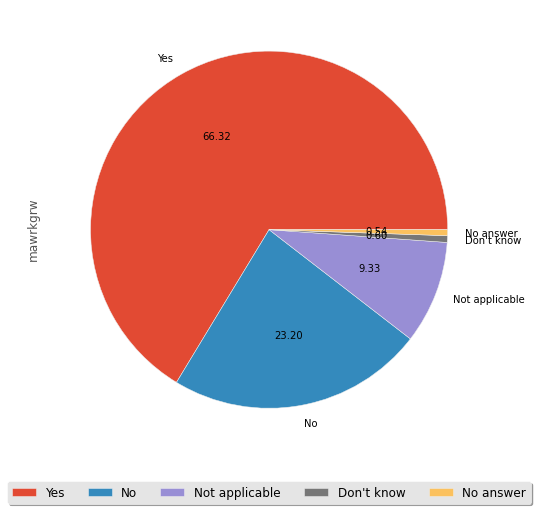

In [132]:
simple_pie(df.mawrkgrw)

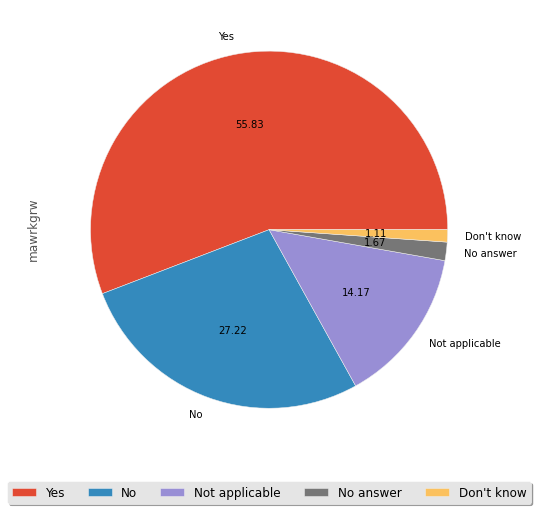

In [135]:
simple_pie(df_c3.mawrkgrw)